In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import itertools
from xgboost.sklearn import XGBClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score,f1_score, accuracy_score, precision_recall_curve,confusion_matrix
!pip install shap
from sklearn.model_selection import train_test_split
!pip install category_encoders
from category_encoders import TargetEncoder
# import xgboost model
import xgboost as xgb
from xgboost import XGBRegressor as XGBR  
from xgboost import plot_importance,plot_tree
from sklearn.model_selection import KFold,cross_val_score as CVS,train_test_split as TTS  # import cross validation, KFold
from sklearn.preprocessing import MinMaxScaler    
from sklearn.metrics import log_loss, roc_auc_score, auc, accuracy_score,roc_curve, mean_squared_error as MSE   # calculate
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from sklearn import metrics

In [ ]:
# function for plotting confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
# data import
url = 'https://github.com/qiuke12321/CS/blob/main/Application_Data.csv?raw=true'
data = pd.read_csv(url, index_col=0)

# Part I: Data Exploratory

In [ ]:
print(data.head(5))
print(data.info())
print(data.describe())
print(data.isnull().sum())

             Applicant_Gender  Owned_Car  Owned_Realty  Total_Children  \
Applicant_ID                                                             
5008806               M                1             1               0   
5008808               F                0             1               0   
5008809               F                0             1               0   
5008810               F                0             1               0   
5008811               F                0             1               0   

              Total_Income                                        Income_Type  \
Applicant_ID                                                                    
5008806             112500  Working                                       ...   
5008808             270000  Commercial associate                          ...   
5008809             270000  Commercial associate                          ...   
5008810             270000  Commercial associate                          ..

## Part II: Data preparation

### 1. resample

0.12277141037886023

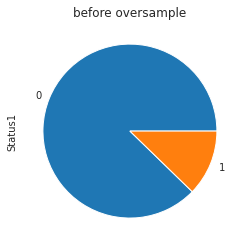

In [ ]:
# data distribution before resample
data['Status1'].value_counts().plot(kind = 'pie',title = 'before oversample')
len(data[data['Status1'] == 1])/len(data)

In [ ]:
# data split and rebalance of training set
data2 = data.copy() 
data2 = data2.drop(columns = ['Status','Status2'])
X = data2.drop(columns = ['Status1','Total_Bad_Debt'])
y = data2[['Status1']]
# split data set into train and test set
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size = 0.3,random_state = 27)
# rebalance the train set
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state = 27)
x_resample,y_resample = ros.fit_resample(x_train,y_train)

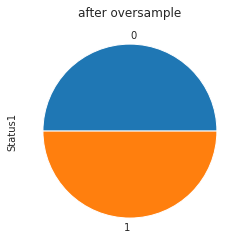

In [ ]:
# data distribution after resample
df_resample = pd.DataFrame(y_resample)
df_resample['Status1'].value_counts().plot(kind = 'pie',title = 'after oversample')

### 2. Target encoding

In [ ]:
data_category = data.select_dtypes(include = 'object')
data_category

,Applicant_Gender,Income_Type,Education_Type,Family_Status,Housing_Type,Job_Title
Applicant_ID,,,,,,
5008806,M,Working ...,Secondary / secondary special ...,Married ...,House / apartment ...,Security staff ...
5008808,F,Commercial associate ...,Secondary / secondary special ...,Single / not married ...,House / apartment ...,Sales staff ...
5008809,F,Commercial associate ...,Secondary / secondary special ...,Single / not married ...,House / apartment ...,Sales staff ...
5008810,F,Commercial associate ...,Secondary / secondary special ...,Single / not married ...,House / apartment ...,Sales staff ...
5008811,F,Commercial associate ...,Secondary / secondary special ...,Single / not married ...,House / apartment ...,Sales staff ...
...,...,...,...,...,...,...
5150482,F,Working ...,Secondary / secondary special ...,Married ...,House / apartment ...,Core staff ...
5150483,F,Working ...,Secondary / secondary special ...,Married ...,House / apartment ...,Core staff ...
5150484,F,Working ...,Secondary / secondary special ...,Married ...,House / apartment ...,Core staff ...


In [ ]:
# loop through each object columns and see what's the unique number and the length
for i in data_category.columns: 
  print('the unique value of {} class is: \n'.format(i))
  print(data_category[i].unique())
  print('with the length of {} \n'.format(len(data_category[i].unique())))

the unique value of Applicant_Gender class is: 

['M      ' 'F      ']
with the length of 2 

the unique value of Income_Type class is: 

['Working                                           '
 'Commercial associate                              '
 'State servant                                     '
 'Student                                           '
 'Pensioner                                         ']
with the length of 5 

the unique value of Education_Type class is: 

['Secondary / secondary special                     '
 'Higher education                                  '
 'Incomplete higher                                 '
 'Lower secondary                                   '
 'Academic degree                                   ']
with the length of 5 

the unique value of Family_Status class is: 

['Married                                           '
 'Single / not married                              '
 'Civil marriage                                    '
 'Separated        

In [ ]:
data_category.columns.tolist()
enc = TargetEncoder(cols = data_category.columns.tolist())
train_numeric = enc.fit_transform(x_resample,y_resample,smoothing = 10) # smoothing is the weights that will assign to overall mean to prevent overfitting and informamtion leakarage
test_numeric = enc.transform(x_test,y_test)

['Applicant_Gender',
 'Income_Type',
 'Education_Type',
 'Family_Status',
 'Housing_Type',
 'Job_Title']

In [ ]:
# construct unique xgboost data sturcture DMatrix
dataTrain = xgb.DMatrix(data = train_numeric,label = y_resample)
dataTest = xgb.DMatrix(data = test_numeric)
# train model: specified xgb parameter
params={'booster':'gbtree',
	    'nthread':12,
	    'objective': 'reg:logistic',
	    'eval_metric':'auc',
	    'seed':0,
	    'eta': 0.01,
	    'gamma':0.1,
	    'min_child_weight':1.1,
	    'max_depth':5,
	    'lambda':10,
	    'subsample':0.7,
	    'colsample_bytree':0.7,
	    'colsample_bylevel':0.7,
	    'tree_method':'exact'}

## Part III: Hyperparameter tunning




### 1. number of optimal num_boost_round

In [ ]:
# find optimum num_boost_round
cvresult = xgb.cv(params, dataTrain, num_boost_round=1000, nfold=5, metrics='auc', seed=0, callbacks=[
            xgb.callback.print_evaluation(show_stdv=False),
            xgb.callback.early_stop(50) # stop the loop when metrics didn't improved in the recent 50 loops
            ])
num_round_best = cvresult.shape[0] - 1

[0]	train-auc:0.607559	test-auc:0.595318
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
[1]	train-auc:0.634894	test-auc:0.62175
[2]	train-auc:0.651223	test-auc:0.635292
[3]	train-auc:0.657631	test-auc:0.640574
[4]	train-auc:0.668778	test-auc:0.652583
[5]	train-auc:0.672623	test-auc:0.655894
[6]	train-auc:0.677194	test-auc:0.659506
[7]	train-auc:0.681018	test-auc:0.663473
[8]	train-auc:0.686323	test-auc:0.667084
[9]	train-auc:0.687827	test-auc:0.668304
[10]	train-auc:0.690373	test-auc:0.670393
[11]	train-auc:0.691113	test-auc:0.670574
[12]	train-auc:0.691896	test-auc:0.670756
[13]	train-auc:0.691306	test-auc:0.670785
[14]	train-auc:0.691264	test-auc:0.670275
[15]	train-auc:0.692258	test-auc:0.671198
[16]	train-auc:0.69454	test-auc:0.673495
[17]	train-auc:0.694242	test-auc:0.673034
[18]	train-auc:0.693735	test-auc:0.673015
[19]	train-auc:0.696459	test-auc:0.675157
[20]	train-auc:0.696799	test-au

In [ ]:
print('the best round number is \n')
num_round_best

the best round number is 



999

In [ ]:
# max_depth,min_weight,n_estimator parameter tunning
param_test1 = {'n_estimators': np.arange(10,200,20)}

In [ ]:
gsearch1 = GridSearchCV(
estimator = XGBClassifier(learning_rate =0.1, max_depth=5,min_child_weight=1, gamma=0, subsample=0.8,
colsample_bytree=0.8,objective= 'reg:logistic', nthread=4,scale_pos_weight=1, seed=27), 
param_grid = param_test1,scoring='roc_auc',n_jobs=4, cv=5)

gsearch1.fit(train_numeric,y_resample)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GridSearchCV(cv=5,
             estimator=XGBClassifier(colsample_bytree=0.8, max_depth=5,
                                     nthread=4, objective='reg:logistic',
                                     seed=27, subsample=0.8),
             n_jobs=4,
             param_grid={'n_estimators': array([ 10,  30,  50,  70,  90, 110, 130, 150, 170, 190])},
             scoring='roc_auc')

In [ ]:
gsearch1.best_score_, gsearch1.best_params_

(0.8562136965480811, {'n_estimators': 190})

### 2. number of optimal num_boost_round

In [ ]:
param_test2 = {'learning_rate': np.linspace(0,1,20)}

In [ ]:
gsearch2 = GridSearchCV(
estimator = XGBClassifier(n_estimators=190, max_depth=5,min_child_weight=1, gamma=0, subsample=0.8,
colsample_bytree=0.8,objective= 'reg:logistic', nthread=4,scale_pos_weight=1, seed=27), 
param_grid = param_test2,scoring='roc_auc',n_jobs=4, cv=5)

gsearch2.fit(train_numeric,y_resample)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GridSearchCV(cv=5,
             estimator=XGBClassifier(colsample_bytree=0.8, max_depth=5,
                                     n_estimators=190, nthread=4,
                                     objective='reg:logistic', seed=27,
                                     subsample=0.8),
             n_jobs=4,
             param_grid={'learning_rate': array([0.        , 0.05263158, 0.10526316, 0.15789474, 0.21052632,
       0.26315789, 0.31578947, 0.36842105, 0.42105263, 0.47368421,
       0.52631579, 0.57894737, 0.63157895, 0.68421053, 0.73684211,
       0.78947368, 0.84210526, 0.89473684, 0.94736842, 1.        ])},
             scoring='roc_auc')

In [ ]:
gsearch2.best_score_, gsearch2.best_params_

(0.9677861611579706, {'learning_rate': 1.0})

### 3.max_depth and min_child_weight

In [ ]:
param_test3 = {'max_depth': np.arange(1,6,1),'min_child_weight' : np.arange(2,10,2)}
gsearch3 = GridSearchCV(estimator = XGBClassifier(learning_rate = 1, n_estimators=190, gamma=0, subsample=0.8, colsample_bytree=0.8, objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), param_grid = param_test3, scoring='roc_auc',n_jobs=4,cv=5)

gsearch3.fit(train_numeric, y_resample)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GridSearchCV(cv=5,
             estimator=XGBClassifier(colsample_bytree=0.8, learning_rate=1,
                                     n_estimators=190, nthread=4, seed=27,
                                     subsample=0.8),
             n_jobs=4,
             param_grid={'max_depth': array([1, 2, 3, 4, 5]),
                         'min_child_weight': array([2, 4, 6, 8])},
             scoring='roc_auc')

In [ ]:
gsearch3.best_score_, gsearch3.best_params_

(0.9640918807555725, {'max_depth': 5, 'min_child_weight': 2})

### 4.alpha for regularization

In [ ]:
param_test4 = {
 'alpha':np.linspace(0,1,20)
}
gsearch4 = GridSearchCV(estimator = XGBClassifier(learning_rate =1, n_estimators=190, max_depth=5, min_child_weight=2, subsample=0.8, colsample_bytree=0.8, objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), param_grid = param_test4, scoring='roc_auc',n_jobs=4, cv=5)

gsearch4.fit(train_numeric, y_resample)


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


GridSearchCV(cv=5,
             estimator=XGBClassifier(colsample_bytree=0.8, learning_rate=1,
                                     max_depth=5, min_child_weight=2,
                                     n_estimators=190, nthread=4, seed=27,
                                     subsample=0.8),
             n_jobs=4,
             param_grid={'alpha': array([0.        , 0.05263158, 0.10526316, 0.15789474, 0.21052632,
       0.26315789, 0.31578947, 0.36842105, 0.42105263, 0.47368421,
       0.52631579, 0.57894737, 0.63157895, 0.68421053, 0.73684211,
       0.78947368, 0.84210526, 0.89473684, 0.94736842, 1.        ])},
             scoring='roc_auc')

In [ ]:
gsearch4.best_score_, gsearch4.best_params_

(0.9383431770115853, {'alpha': 0.0})

## Part IV: Model evaluation

In [ ]:
xg_reg = XGBClassifier(objective='binary:logistic',colsample_bytree= 0.8,learning_rate= 1 ,max_depth= 5, n_estimators = 190,
          min_child_weight= 2,alpha=0)
xg_reg.fit(train_numeric,y_resample)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


XGBClassifier(alpha=0, colsample_bytree=0.8, learning_rate=1, max_depth=5,
              min_child_weight=2, n_estimators=190)

In [ ]:
y_pred = xg_reg.predict(test_numeric)

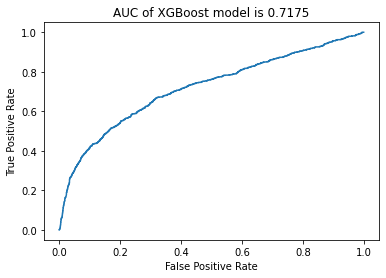

In [ ]:
#plot roc curve

y_pred_proba = xg_reg.predict_proba(test_numeric)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)

#create ROC curve
plt.plot(fpr,tpr)
plt.title('AUC of XGBoost model is {:.4f}'.format(roc_auc_score(y_test,y_pred_proba)))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

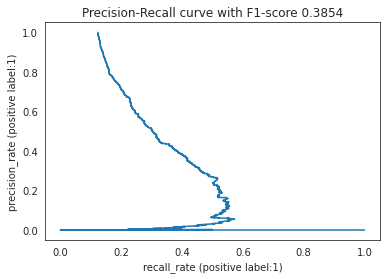

In [ ]:
# plot precision_recall_curve
precision,recall,thresholds = precision_recall_curve(y_test,y_pred_proba)
plt.plot(precision,recall)
plt.xlabel('recall_rate (positive label:1)')
plt.ylabel('precision_rate (positive label:1)')
plt.title('Precision-Recall curve with F1-score {:.4f}'.format(f1_score(y_test,y_pred)))
plt.show()

[[0.88286925 0.11713075]
 [0.56283566 0.43716434]]


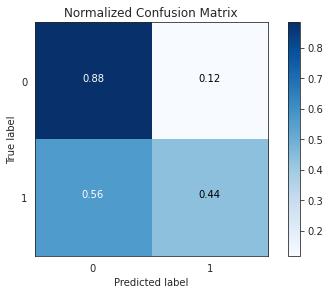

In [ ]:
sns.set_style('white') 
class_names = ['0','1']
plot_confusion_matrix(confusion_matrix(y_test, y_pred),
                      classes= class_names, normalize = True, 
                      title='Normalized Confusion Matrix')

In [ ]:
confusion_matrix(y_test, y_pred)

array([[5834,  774],
       [ 524,  407]])

In [ ]:
#accuracy score
accuracy_score(y_test,y_pred)

0.8278286244860061

In [ ]:
# f1_score
f1_score(y_test,y_pred)

0.38541666666666663

## Part V: Model explanation

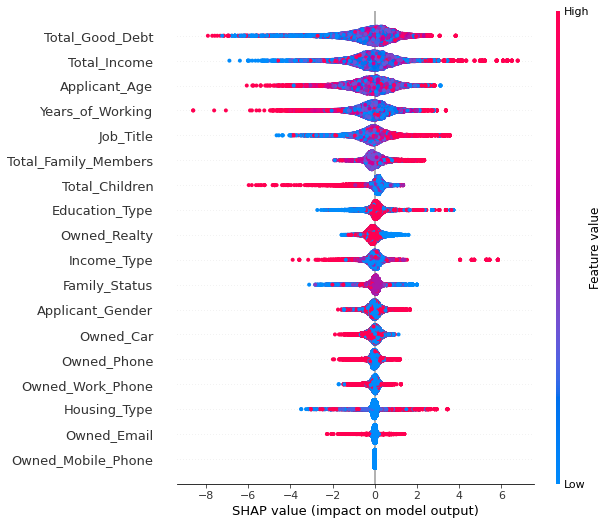

In [ ]:
# shap value graph
import shap
shap_values = shap.TreeExplainer(xg_reg).shap_values(train_numeric)
shap.summary_plot(shap_values,train_numeric)

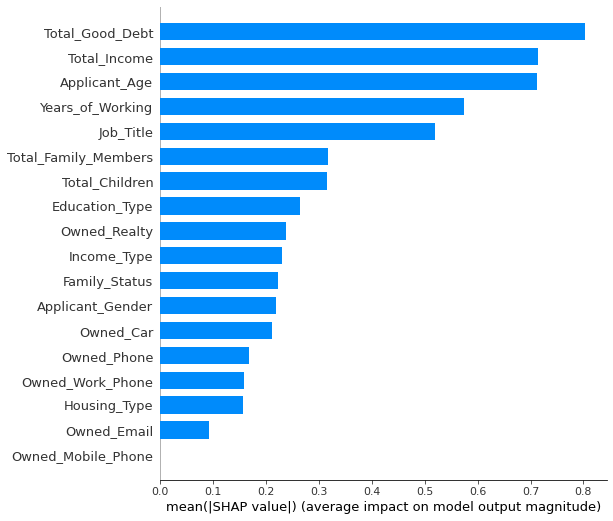

In [ ]:
# shap important graph
shap.summary_plot(shap_values,train_numeric,plot_type = "bar")